# Project 4

## Problem 1

Solve the wave equation 

$$\frac{\partial^2 u(t,x)}{\partial t^2} = \frac{\partial^2 u(t,x)}{\partial x^2} $$  

numerically. Use a $1+1$-dimensional domain, and use Dirichlet boundary conditions $u(t,-L) = u(t,+L) = 0$. Use the spatial domain bounds $[-1; +1]$, and use the Gaussian-like function 

$$f(t,x) = A \ exp{\left(-\frac{1}{2} \frac{\sin^2(2 \pi (x-t)) }{W^2} \right)}$$ 

as initial condition. Use $L=1, A=1, W=0.2$ as parameters. Evolve from $t=0$ to $t=4L$, i.e. for two crossing times. Plot the result.

### Solution:

In [1]:
using CairoMakie
using LinearAlgebra

In [2]:
A = 1
W = 0.2
L = 1;

In [3]:
function coords(nn, ni, dt, dx)
    t = [n * dt for i in -ni:ni, n in 0:nn]
    x = [i * dx for i in -ni:ni, n in 0:nn]
    return t, x
end;

The initial condition

$$f(t,x) = A \ exp{\left(-\frac{1}{2} \frac{\sin^2(2 \pi (x-t)) }{W^2} \right)}$$ 

provided in the question is not consistent with the boundary condition, because at $x\to 1, t \to 0$ initial condition produces $u(0,1)=1$ although boundary condition is $u(0,1)=0$. To avoid inconsistency, we shifted the Gaussian initial condition to half wavelength. The inital wavefunction would like the following:

\begin{eqnarray*}
f(t,x) &=& A \ exp{\left(-\frac{1}{2} \frac{\sin^2(2 \pi (x-t+0.25)) }{W^2} \right)}\\
&=& A \ exp{\left(-\frac{1}{2} \frac{\cos^2(2 \pi (x-t)) }{W^2} \right)}
\end{eqnarray*}

In [4]:
# Define initial conditions for a standing wave
function inital_condition(t, x)
    ni, nn = size(t)
    u = zeros(ni, nn)
    # Initial conditions for first two points in time
    # f(t,x) = A exp(-0.5*cos^2(2 π (x-t))/W^2)
    for n in 1:2, i in 1:ni
        u[i, n] = A * exp.(-0.5*(cos(2*π * (x[i, n]-t[i,n])))^2/W^2)
    end
    return u
end;

In [5]:
function evolve_point!(u, dt, dx, n, i)
    ni, nn = size(u)
    # Finite difference for second derivative in x direction at point [i,n-1]
    uxx = (u[i-1,n-1] - 2*u[i,n-1] + u[i+1,n-1]) / dx^2
    # Time derivative
    u[i,n] = uxx * dt^2 - u[i,n-2] + 2*u[i,n-1]
    return
end;

In [6]:
function evolve_step!(u, dt, dx, n)
    ni, nn = size(u)
    # Apply boundary condition at left boundary
    u[1,n] = 0
    # Evolve interior
    for i in 2:ni-1
        evolve_point!(u, dt, dx, n, i)
    end
    # Apply boundary condition at right boundary
    u[ni,n] = 0
    return
end;

In [7]:
function evolve!(u, dt, dx)
    ni, nn = size(u)
    # Loop over all times
    for n in 3:nn
        evolve_step!(u, dt, dx, n)
    end
    return
end;

In [8]:
nn = 400
ni = 100
dt = 4 / nn
dx = 1 / ni
t, x = coords(nn, ni, dt, dx);

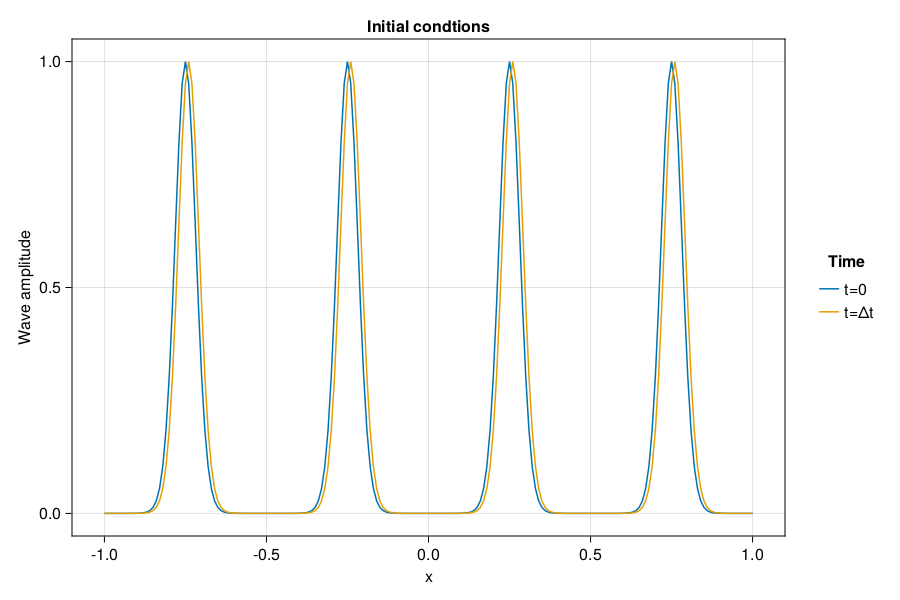

In [9]:
u = inital_condition(t, x);
fig = Figure(resolution = (900, 600))
ax = Axis(fig[1, 1], xlabel="x", ylabel="Wave amplitude", title="Initial condtions")
lines!(x[:,1],u[:,1],label="t=0")
lines!(x[:,2],u[:,2],label="t=Δt")
fig[1, 2] = Legend(fig, ax, "Time", framevisible = false)
fig

In [10]:
evolve!(u, dt, dx)

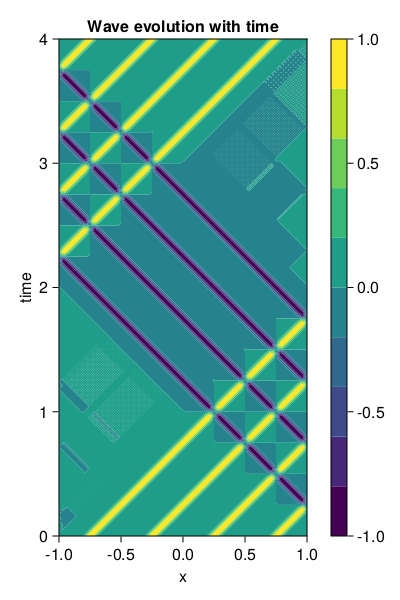

In [11]:
fig = Figure(resolution = (400, 600))
ax = Axis(fig[1, 1],title="Wave evolution with time",xlabel="x",ylabel="time")
co = contourf!(fig[1,1], vec(x), vec(t), vec(u))
Colorbar(fig[1,2],co)
fig

**Remarks:** This wave pattern makes sense because of the hard boundary the wave crest gets reflected to $\pm 1$ to $\mp 1$ at each boundary and bounced back. Moreover, when two opposite crest meet it causes destructive interference which is clear in the above picture.

## Problem 2

Vary the time step size `dt`. If you choose `dt` too large, the discrete system will be unstable. What is the stability limit? Why does this happen? How could you avoid this limit?

### Solution:

Just for illustration purpouse we have used `dt` = $1.25$ `dx`. This gives a very unstable solution and the waveamplitude grows unbounded in this case. To demostrate the effect here we have plotted $log|u|$ here below.

In [12]:
dt = 5 / nn #dt = 1.25 dx
t, x = coords(nn, ni, dt, dx);
u = inital_condition(t, x);
evolve!(u, dt, dx)

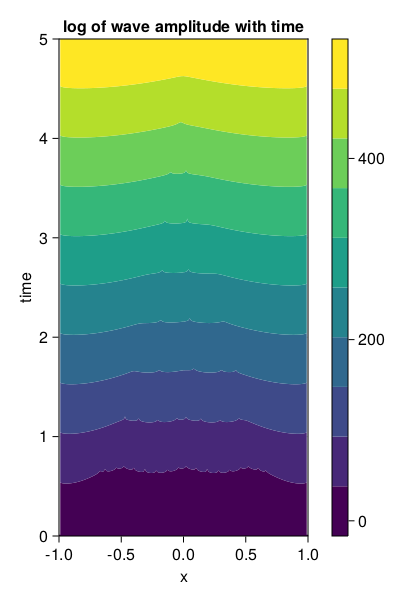

In [13]:
fig = Figure(resolution = (400, 600))
ax = Axis(fig[1, 1],title="log of wave amplitude with time",xlabel="x",ylabel="time")
co = contourf!(fig[1,1], vec(x), vec(t), log.(abs.(vec(u))))
Colorbar(fig[1,2],co)
fig

**Stabiity condition:** From the Courant–Friedrichs–Lewy condition 

\begin{equation*}
\frac{v \Delta t}{\Delta x} \leq C_{CFL}
\end{equation*}

we can estimate that for this particular problem. For our particular setup velocity of wave propagation $v=1$ and Courant number $C_{CFL}=1$. Hence, the discrete time difference must be less than equal to discrete location difference in order for the solution to be stable i.e. `dt` $\leq$ `dx`.

**Explanation:**  If the *stability condition* is violated we end up computing numerically the waveamplitude before the actual wave reaches the space-time point (with velocity $v=1$). Hence, we are getting unphysical result from numerical solution. 

**Ways to avoid the limit:**
- Increase the value of `dx` keeping `dt` fixed.
- Decrease the value of `dt` keeping `dx` fixed.
- Use different algorithm (e.g. implicit Euler method) to increase $C_{CFL}$.

## Problem 3

The energy density of a scalar wave is 

$$ \epsilon(t,x) = \frac{1}{2} \left[ \left(\frac{d u(t,x)}{dt}\right)^2 + \left(\frac{d u(t,x)}{dx}\right)^2 \right]$$

Calculate the energy density as a function of space and time for your solution. Plot the result.

### Solution:

In [14]:
dt = 4 / nn #dt = dx
t, x = coords(nn, ni, dt, dx);
u = inital_condition(t, x);
evolve!(u, dt, dx)

We will take center derivative to calculate bulk energy density here. We will use forward and backward derivative for all the peripheral points. 

In [15]:
function energy_density(u,dx,dt)
    dudx = similar(u)
    dudt = similar(u)
    # center derivate in x direction only for the bulk region
    dudx[2:end-1,:] = (u[3:end,:]-u[1:end-2,:])./(2*dx) 
    # now we handle boundary with forward and backward derivative respectively
    dudx[1,:] = (u[2,:]-u[1,:])./(dx) 
    dudx[end,:] = (u[end,:]-u[end-1,:])./(dx) 
    # center derivate in t direction only for the bulk region
    dudt[:,2:end-1] = (u[:,3:end]-u[:,1:end-2])./(2*dt) 
    # now we handle boundary with forward and backward derivative respectively
    dudt[:,1] = (u[:,2]-u[:,1])./(dt) 
    dudt[:,end] = (u[:,end]-u[:,end-1])./(dt) 
    # energy density formula for each location 
    return ϵ = 0.5*(dudx.^2 .+ dudt.^2)
end;

In [16]:
ϵ = energy_density(u,dx,dt);

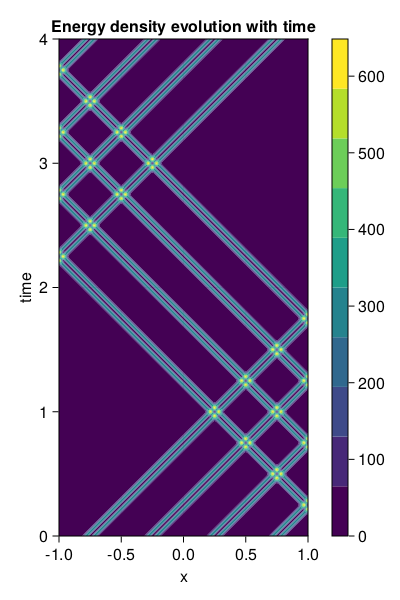

In [17]:
fig = Figure(resolution = (400, 600))
ax = Axis(fig[1, 1],title="Energy density evolution with time",xlabel="x",ylabel="time")
co = contourf!(fig[1,1], vec(x), vec(t), vec(ϵ))
Colorbar(fig[1,2],co)
fig

## Problem 4

To calculate the total energy `E(t)` as a function of time, you need to integrate it over space. One way to do so is using the function below. Calculate and show the total energy `E(t)` as a function of time. How well is the energy conserved? How does this depend on the grid spacings `dx` and `dt`?

In [18]:
# Integrate `epsilon` over space
function integrate(epsilon, n, dx)
    ni, nt = size(epsilon)
    # The boundary points are special; they have a weight of 1/2.
    # There are `ni` points overall, and the grid spacing is `dx = 2L/(ni-1)`.
    # Integrating the constant function `epsilon=1` thus gives exactly `2L`.
    E = epsilon[1, n] / 2
    for i in 2:ni-1
        E += epsilon[i, n]
    end
    E += epsilon[ni, n] / 2
    # Scale by the grid spacing
    E *= dx
    return E
end;

### Solution:

In [19]:
E = [integrate(ϵ,i,dx) for i in 1:(nn+1)];

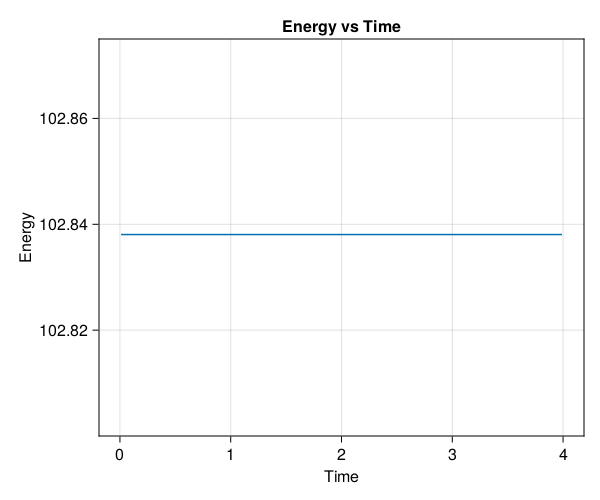

In [20]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="Energy", title="Energy vs Time")
lines!(t[1,2:end-1],E[2:end-1]) # energy in bulk region
ylims!(102.8, 102.875)
fig

**Remarks:** From the plot it is apparent that here energy is well-consevered.  

**Case 1:** $\frac{\Delta t}{\Delta x} = 0.75$

In [21]:
dt = 3 / nn #dt = 0.75 dx
t, x = coords(nn, ni, dt, dx);
u = inital_condition(t, x);
evolve!(u, dt, dx)
ϵ = energy_density(u,dx,dt);
E = [integrate(ϵ,i,dx) for i in 1:(nn+1)];

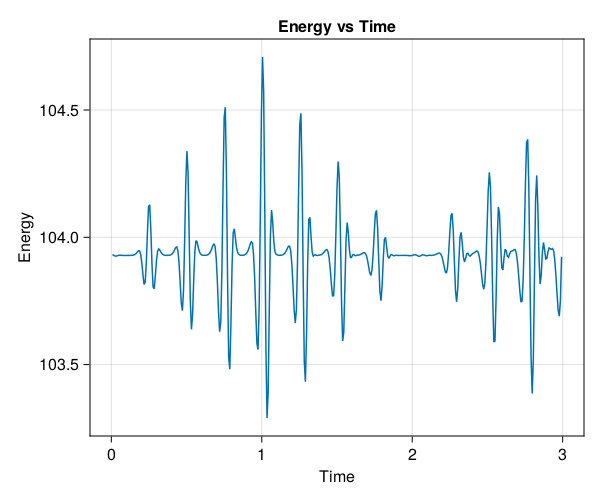

In [22]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="Energy", title="Energy vs Time")
lines!(t[1,2:end-1],(E[2:end-1])) # energy in bulk region
fig

**Remarks**: Energy conservation is stable most of the time; however, it fluctuates when waves bounces at the boundary or collides with each other. 

**Case 2:** $\frac{\Delta t}{\Delta x} = 0.5$

In [23]:
dt = 2 / nn #dt = 0.5 dx
t, x = coords(nn, ni, dt, dx);
u = inital_condition(t, x);
evolve!(u, dt, dx)
ϵ = energy_density(u,dx,dt);
E = [integrate(ϵ,i,dx) for i in 1:(nn+1)];

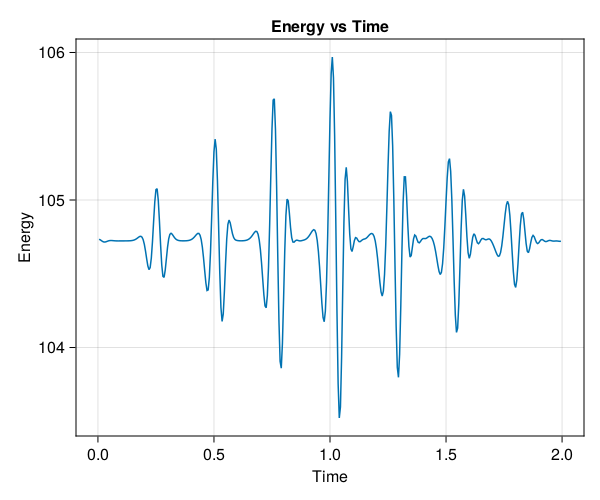

In [24]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="Energy", title="Energy vs Time")
lines!(t[1,2:end-1],(E[2:end-1])) # energy in bulk region
fig

**Remarks:** Energy conservation is more or less fine, but the fluctuation due to numerical error is worse than pervious case.

**Case 3:** $\frac{\Delta t}{\Delta x} = 0.375$

In [25]:
dt = 1.5 / nn
t, x = coords(nn, ni, dt, dx);
u = inital_condition(t, x);
evolve!(u, dt, dx)
ϵ = energy_density(u,dx,dt);
E = [integrate(ϵ,i,dx) for i in 1:(nn+1)];

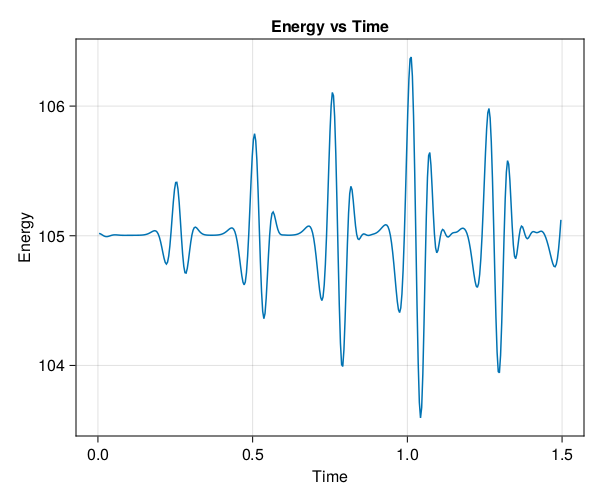

In [26]:
fig = Figure(resolution = (600, 500))
ax = Axis(fig[1, 1], xlabel="Time", ylabel="Energy", title="Energy vs Time")
lines!(t[1,2:end-1],(E[2:end-1])) # energy in bulk region
fig

**Remarks:** Energy fluctuation due to numerical error is worse than pervious case. We can estimate that numerical error will grow if reduce the `dt` and `dx`. However, if we ignore the periodic fluctuation ($<2\%$) here, energy is pretty much conserved for all three cases,